In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
data_path = '/content/drive/My Drive/AML_Assignment_2/IMDB Dataset.csv'
train=pd.read_csv(data_path)
train.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
y_train = train["sentiment"].map({"negative": 0, "positive": 1})
X = train["review"]

In [5]:
train.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
stopwords_eng = set(stopwords.words("english"))
#Removing the html strips
def strip_html(text):
    p = re.compile(r'<.*?>')
    return p.sub('', text)


def clean_text(text):
    text = text.lower() # convert to lowercase
    text = strip_html(text)
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopwords_eng]
    text = " ".join(words)
    return text

X_train = X.map(clean_text)
X_train.head()

0    one reviewers mentioned watching oz episode ho...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically family little boy jake thinks zombie...
4    petter mattei love time money visually stunnin...
Name: review, dtype: object

In [7]:
num_words = 6000
tokenizer = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(X_train)

X_train_seq = pd.Series(tokenizer.texts_to_sequences(X_train))
X_train_seq.head()

0    [3, 1897, 916, 55, 2915, 275, 3029, 98, 486, 4...
1    [271, 41, 234, 1228, 2807, 61, 6, 1999, 1430, ...
2    [89, 271, 22, 1003, 6, 725, 1317, 2429, 1088, ...
3    [550, 119, 41, 278, 3174, 1101, 850, 4036, 628...
4    [33, 6, 176, 1974, 1273, 2, 27, 314, 1414, 76,...
dtype: object

In [8]:
X_train_len = X_train_seq.map(lambda ls: len(ls))
X_train_len.describe()

count    50000.000000
mean        99.489800
std         72.206902
min          3.000000
25%         55.000000
50%         75.000000
75%        121.000000
max        967.000000
dtype: float64

Review length: 
Mean 813.93 words (631.115546)


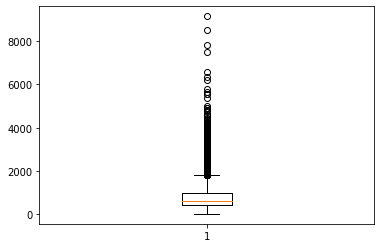

In [ ]:
# Summarize review length
print("Review length: ")
result = [len(x) for x in X_train]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
pyplot.boxplot(result)
pyplot.show()

In [9]:
from keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_seq, maxlen=2000)
X_train_pad

array([[   0,    0,    0, ..., 1065, 3915,  356],
       [   0,    0,    0, ..., 1811,   12,  113],
       [   0,    0,    0, ...,   51,   11,  232],
       ...,
       [   0,    0,    0, ...,  365, 3801, 5760],
       [   0,    0,    0, ..., 1919, 3999,  595],
       [   0,    0,    0, ..., 4263,  652,    1]], dtype=int32)

In [10]:
drop=0.5            #factor by whcih LR drops after every epoch
epochs_drop=1.0     #number of epochs after which the LR must decrease
initial_lr=0.01 

In [11]:
import math
from tensorflow.keras.callbacks import LearningRateScheduler
decay_rate=[]
def step_decay(epoch):
  lr=initial_lr*math.pow(drop, math.floor((1+epoch)/epochs_drop))
  decay_rate.append(lr)

  return lr

lr=LearningRateScheduler(step_decay)
callback=[lr]

In [12]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalMaxPool1D, Dropout

#USING 2 DENSE LAYERS

In [13]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalMaxPool1D, Dropout

model = Sequential()

model.add(Embedding(input_dim=num_words, output_dim=64))
model.add(LSTM(32, return_sequences=True))
#model.add(LSTM(32))
model.add(GlobalMaxPool1D())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          384000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          12416     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 396,961
Trainable params: 396,961
Non-trainable params: 0
__________________________________________________

In [14]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [15]:
batch_size = 32
epochs = 10
validation_split = 0.1
model.fit(x=X_train_pad, y=y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/10
1407/1407 [==============================] - 102s 73ms/step - loss: 0.3592 - accuracy: 0.8460 - val_loss: 0.2891 - val_accuracy: 0.8808
Epoch 2/10
1407/1407 [==============================] - 100s 71ms/step - loss: 0.2446 - accuracy: 0.9066 - val_loss: 0.2855 - val_accuracy: 0.8836
Epoch 3/10
1407/1407 [==============================] - 98s 70ms/step - loss: 0.2008 - accuracy: 0.9263 - val_loss: 0.3033 - val_accuracy: 0.8778
Epoch 4/10
1407/1407 [==============================] - 102s 73ms/step - loss: 0.1588 - accuracy: 0.9450 - val_loss: 0.3195 - val_accuracy: 0.8816
Epoch 5/10
1407/1407 [==============================] - 101s 72ms/step - loss: 0.1202 - accuracy: 0.9606 - val_loss: 0.3481 - val_accuracy: 0.8708
Epoch 6/10
1407/1407 [==============================] - 103s 73ms/step - loss: 0.0896 - accuracy: 0.9712 - val_loss: 0.4158 - val_accuracy: 0.8744
Epoch 7/10
1407/1407 [==============================] - 106s 75ms/step - loss: 0.0595 - accuracy: 0.9818 - val_loss: 0.

##Using LR Scheduling with 2-dense layer model 

In [16]:
model_lr = Sequential()

model_lr.add(Embedding(input_dim=num_words, output_dim=64))
model_lr.add(LSTM(32,dropout=0.3, return_sequences=True))
model_lr.add(GlobalMaxPool1D())
model_lr.add(Dense(16, activation='relu'))
model_lr.add(Dropout(0.2))
model_lr.add(Dense(1, activation='sigmoid'))
model_lr.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          384000    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          12416     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 396,961
Trainable params: 396,961
Non-trainable params: 0
________________________________________________

In [17]:
model_lr.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [18]:
batch_size = 32
epochs = 5
validation_split = 0.1
model_lr.fit(x=X_train_pad, y=y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split,callbacks=callback)

Epoch 1/5
1407/1407 [==============================] - 110s 78ms/step - loss: 0.3514 - accuracy: 0.8478 - val_loss: 0.2883 - val_accuracy: 0.8850
Epoch 2/5
1407/1407 [==============================] - 106s 75ms/step - loss: 0.2229 - accuracy: 0.9155 - val_loss: 0.2905 - val_accuracy: 0.8860
Epoch 3/5
1407/1407 [==============================] - 104s 74ms/step - loss: 0.1632 - accuracy: 0.9418 - val_loss: 0.3131 - val_accuracy: 0.8878
Epoch 4/5
1407/1407 [==============================] - 104s 74ms/step - loss: 0.1243 - accuracy: 0.9589 - val_loss: 0.3410 - val_accuracy: 0.8888
Epoch 5/5
1407/1407 [==============================] - 102s 73ms/step - loss: 0.1039 - accuracy: 0.9668 - val_loss: 0.3664 - val_accuracy: 0.8846


#USING STACKED LSTM

In [20]:
model_1 = Sequential()

model_1.add(Embedding(input_dim=num_words, output_dim=64))
model_1.add(LSTM(32, return_sequences=True))
model_1.add(LSTM(32))
model_1.add(Dropout(0.2))
model_1.add(Dense(1, activation='sigmoid'))

model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          384000    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          12416     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 404,769
Trainable params: 404,769
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 5
validation_split = 0.1
model_1.fit(x=X_train_pad, y=y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/5
1407/1407 [==============================] - 181s 129ms/step - loss: 0.3424 - accuracy: 0.8526 - val_loss: 0.2895 - val_accuracy: 0.8790
Epoch 2/5
1407/1407 [==============================] - 175s 125ms/step - loss: 0.2396 - accuracy: 0.9047 - val_loss: 0.2854 - val_accuracy: 0.8868
Epoch 3/5
1407/1407 [==============================] - 176s 125ms/step - loss: 0.1962 - accuracy: 0.9256 - val_loss: 0.3194 - val_accuracy: 0.8836
Epoch 4/5
1407/1407 [==============================] - 192s 137ms/step - loss: 0.1599 - accuracy: 0.9394 - val_loss: 0.3233 - val_accuracy: 0.8786
Epoch 5/5
1141/1407 [=======================>......] - ETA: 35s - loss: 0.1311 - accuracy: 0.9526

##USING LR scheduling in STACKED LSTM model

In [52]:
model_1_lr = Sequential()

model_1_lr.add(Embedding(input_dim=num_words, output_dim=64))
model_1_lr.add(LSTM(32,dropout=0.3, return_sequences=True))
model_1_lr.add(LSTM(32,dropout=0.3))
model_1_lr.add(Dropout(0.2))
model_1_lr.add(Dense(1, activation='sigmoid'))

model_1_lr.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          384000    
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 32)          12416     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 404,769
Trainable params: 404,769
Non-trainable params: 0
_________________________________________________________________


In [53]:
model_1_lr.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [54]:
batch_size = 32
epochs = 5
validation_split = 0.1
model_1_lr.fit(x=X_train_pad, y=y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split,callbacks=callback)

Epoch 1/5
1407/1407 [==============================] - 177s 126ms/step - loss: 0.3774 - accuracy: 0.8396 - val_loss: 0.3018 - val_accuracy: 0.8744
Epoch 2/5
1407/1407 [==============================] - 178s 127ms/step - loss: 0.2436 - accuracy: 0.9051 - val_loss: 0.2692 - val_accuracy: 0.8878
Epoch 3/5
1407/1407 [==============================] - 178s 127ms/step - loss: 0.1907 - accuracy: 0.9281 - val_loss: 0.2778 - val_accuracy: 0.8950
Epoch 4/5
1407/1407 [==============================] - 178s 127ms/step - loss: 0.1528 - accuracy: 0.9444 - val_loss: 0.2943 - val_accuracy: 0.8944
Epoch 5/5
1407/1407 [==============================] - 180s 128ms/step - loss: 0.1294 - accuracy: 0.9545 - val_loss: 0.3212 - val_accuracy: 0.8946


#Testing on Rotten Tomatoes Dataset for sentiment analysis.

In [24]:
new_data=r'/content/drive/My Drive/AML_Assignment_2/rotten_tomatoes_reviews.csv'
new=pd.read_csv(new_data)

In [25]:
X_new = new["Review"][:22500]
#X_new = X_new.map(clean_text)
X_new.head()

0     Manakamana doesn't answer any questions, yet ...
1     Wilfully offensive and powered by a chest-thu...
2     It would be difficult to imagine material mor...
3     Despite the gusto its star brings to the role...
4     If there was a good idea at the core of this ...
Name: Review, dtype: object

In [26]:
X_new_seq = pd.Series(tokenizer.texts_to_sequences(X_new))
X_new_seq.head()

0    [1332, 1025, 133, 66, 111, 4, 249, 1135, 116, ...
1                           [2303, 3934, 5, 1933, 134]
2                    [8, 732, 673, 681, 236, 302, 143]
3          [339, 205, 831, 108, 140, 1147, 4914, 3163]
4    [5, 203, 1654, 2, 3456, 2438, 479, 642, 2299, ...
dtype: object

In [27]:
X_new_pad = pad_sequences(X_new_seq, maxlen=2000)
X_new_pad

array([[   0,    0,    0, ..., 1135,  116, 4650],
       [   0,    0,    0, ...,    5, 1933,  134],
       [   0,    0,    0, ...,  236,  302,  143],
       ...,
       [   0,    0,    0, ...,   11,    3, 1732],
       [   0,    0,    0, ...,  101, 1953, 2871],
       [   0,    0,    0, ..., 2919,  337, 2461]], dtype=int32)

In [55]:
y_pred=model_1_lr.predict(X_new_pad)

In [56]:
y_act=new['Freshness'][:22500]

In [57]:
# Importing the dependancies
from sklearn import metrics

print(metrics.confusion_matrix(y_act, y_pred.round()))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, y_pred.round()))

[[7577 3695]
 [3198 8030]]
              precision    recall  f1-score   support

           0       0.70      0.67      0.69     11272
           1       0.68      0.72      0.70     11228

    accuracy                           0.69     22500
   macro avg       0.69      0.69      0.69     22500
weighted avg       0.69      0.69      0.69     22500



Area under the Receiver Operating Characteristic curve: 0.7610502467027705


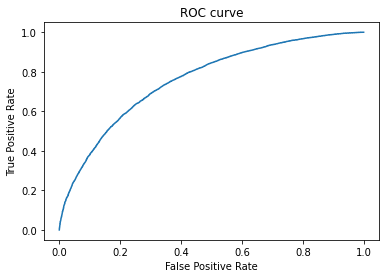

In [58]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_act, y_pred)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc_score(y_act, y_pred))

In [59]:
loss, accuracy = model_1_lr.evaluate(X_new_pad, y_act[:22500], verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

704/704 [==============================] - 42s 59ms/step - loss: 0.7196 - accuracy: 0.6936
Test: accuracy = 0.693644  ;  loss = 0.719641
